# Dependency parsing of the answers

In [1]:
import stanza
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
stanza.download('sv', processors='tokenize,pos,lemma,depparse')
nlp = stanza.Pipeline(lang='sv', processors='tokenize,pos,lemma,depparse')

# Example usage
doc = nlp('Du behöver ta med ditt pass.')
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')

2022-01-24 11:45:50 INFO: Downloading these customized packages for language: sv (Swedish)...
| Processor | Package   |
-------------------------
| tokenize  | talbanken |
| pos       | talbanken |
| lemma     | talbanken |
| depparse  | talbanken |
| pretrain  | talbanken |

2022-01-24 11:45:50 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/tokenize/talbanken.pt.
2022-01-24 11:45:50 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/pos/talbanken.pt.
2022-01-24 11:45:50 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/lemma/talbanken.pt.
2022-01-24 11:45:50 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/depparse/talbanken.pt.
2022-01-24 11:45:51 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/pretrain/talbanken.pt.
2022-01-24 11:45:51 INFO: Finished downloading models and saved to /Users/filippakarrfelt/stanza_resources.
2022-01-24 11:45:51 INFO: Loading these models for language: sv (Swedish):
| Processor | Package  

id: 1	word: Du	head id: 3	head: ta	deprel: nsubj
id: 2	word: behöver	head id: 3	head: ta	deprel: aux
id: 3	word: ta	head id: 0	head: root	deprel: root
id: 4	word: med	head id: 3	head: ta	deprel: compound:prt
id: 5	word: ditt	head id: 6	head: pass	deprel: nmod:poss
id: 6	word: pass	head id: 3	head: ta	deprel: obj
id: 7	word: .	head id: 3	head: ta	deprel: punct


In [10]:
for sentence in doc.sentences:
    for word in sentence.words:
        print(word.text, word.lemma, word.pos, word.deprel)

Du du PRON nsubj
behöver behöva AUX aux
ta ta VERB root
med med ADP compound:prt
ditt du PRON nmod:poss
pass pass NOUN obj
. . PUNCT punct


In [3]:
# Load the dataframes consisting of the data
df_train = pd.read_pickle("./df_train.pkl")
df_test = pd.read_pickle("./df_test.pkl")

In [4]:
# Find the word type of the root in every answer in the dataset
def dependency_parsing(df):
    dependency_dict = {}
    for index, row in df.iterrows():
        answer = row['correct_answer']
        dependency_dict[index] = {'answer': answer, 'word': [], 'pos': [], 'deprel': [], 'root': None, 'root_pos': None}
        doc = nlp(answer)
        for sentence in doc.sentences:
            for word in sentence.words:
                # print(word.text, word.lemma, word.pos, word.deprel)
                dependency_dict[index]['word'].append(word.lemma)
                dependency_dict[index]['pos'].append(word.pos)
                dependency_dict[index]['deprel'].append(word.deprel)
                if word.deprel == 'root':
                    dependency_dict[index]['root'] = word.lemma
                    dependency_dict[index]['root_pos'] = word.pos
    
    return dependency_dict


In [6]:
# get the word class statistics for the root
def get_word_class_count(dict):
    stats = {}
    for ans in dict.values():
        word_pos = ans['root_pos']
        if word_pos not in stats:
            stats[word_pos] = 1
        else:
            stats[word_pos] += 1
    return stats

stats:  {'NOUN': 511, 'VERB': 343, 'NUM': 61, 'ADJ': 24, 'PROPN': 12, 'PRON': 7, 'ADV': 3, 'ADP': 1}


Text(0.5, 1.0, 'Occurrences of word types as DP root')

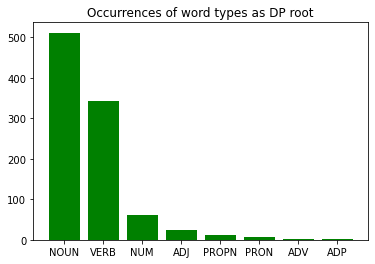

In [19]:
dict = dependency_parsing(df_train)
stats = get_word_class_count(dict)
print('stats: ', stats)
plt.bar(stats.keys(), stats.values(), color='g')
plt.title('Occurrences of word types as DP root')



stats:  {'VERB': 33, 'NOUN': 60, 'NUM': 4, 'ADJ': 3, 'PRON': 1, 'AUX': 1}


Text(0.5, 1.0, 'Occurrences of word types as DP root (test data)')

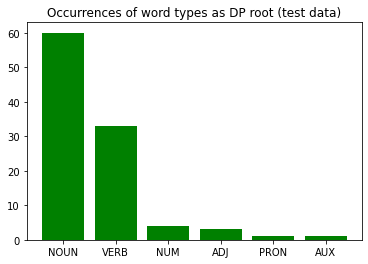

In [9]:
test_dict = dependency_parsing(df_test)
test_stats = get_word_class_count(test_dict)
print('stats: ', test_stats)
test_stats = {k: v for k, v in sorted(test_stats.items(), key=lambda item: item[1], reverse=True)}
plt.bar(test_stats.keys(), test_stats.values(), color='g')
plt.title('Occurrences of word types as DP root (test data)')